# Employee Attrition EDA
Goal: understand drivers of attrition (`left`), check class balance, and surface a few high‑signal features for modeling.


Imports, paths, load data


In [13]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resolve project root robustly
try:
    project_root = Path(__file__).resolve().parents[1]
except NameError:  # __file__ may be undefined in notebook
    project_root = Path.cwd()
    if not (project_root / "data/raw/HR_comma_sep.csv").exists() and project_root.parent.exists():
        project_root = project_root.parent

raw_path = project_root / "data/raw/HR_comma_sep.csv"
df = pd.read_csv(raw_path)

pd.options.display.max_columns = 30
sns.set_theme(style="whitegrid")

print(f"Loaded {raw_path}")
print("Shape:", df.shape)
df.head()


Loaded /Users/chetz/Desktop/Projects/employee-attrition-ml-pipeline/data/raw/HR_comma_sep.csv
Shape: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


 Info & missingness


In [14]:
# Basic schema
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  str    
 9   salary                 14999 non-null  str    
dtypes: float64(2), int64(6), str(2)
memory usage: 1.1 MB


In [15]:
# Missing rates (expect ~0 for this dataset)
missing = df.isna().mean().sort_values(ascending=False)
missing.to_frame("missing_rate")


,missing_rate
satisfaction_level,0.0
last_evaluation,0.0
number_project,0.0
average_montly_hours,0.0
time_spend_company,0.0
Work_accident,0.0
left,0.0
promotion_last_5years,0.0
Department,0.0
salary,0.0


Target balance

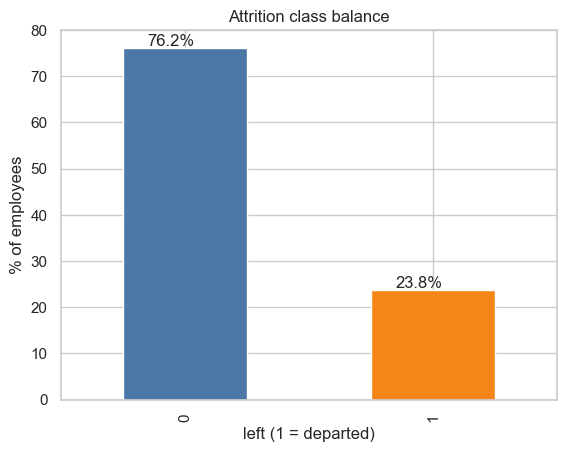

In [16]:
ax = df["left"].value_counts(normalize=True).mul(100).plot(
    kind="bar", color=["#4C78A8", "#F58518"]
)
ax.set_ylabel("% of employees")
ax.set_xlabel("left (1 = departed)")
ax.set_title("Attrition class balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+0.1, p.get_height()+0.5))
plt.show()


Descriptive stats

In [17]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,NaN,NaN,NaN,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,NaN,NaN,NaN,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,NaN,NaN,NaN,3.803054,1.232592,2.0,3.0,4.0,5.0,7.0
average_montly_hours,14999.0,NaN,NaN,NaN,201.050337,49.943099,96.0,156.0,200.0,245.0,310.0
time_spend_company,14999.0,NaN,NaN,NaN,3.498233,1.460136,2.0,3.0,3.0,4.0,10.0
Work_accident,14999.0,NaN,NaN,NaN,0.14461,0.351719,0.0,0.0,0.0,0.0,1.0
left,14999.0,NaN,NaN,NaN,0.238083,0.425924,0.0,0.0,0.0,0.0,1.0
promotion_last_5years,14999.0,NaN,NaN,NaN,0.021268,0.144281,0.0,0.0,0.0,0.0,1.0
Department,14999,10,sales,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,14999,3,low,7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Numeric distributions

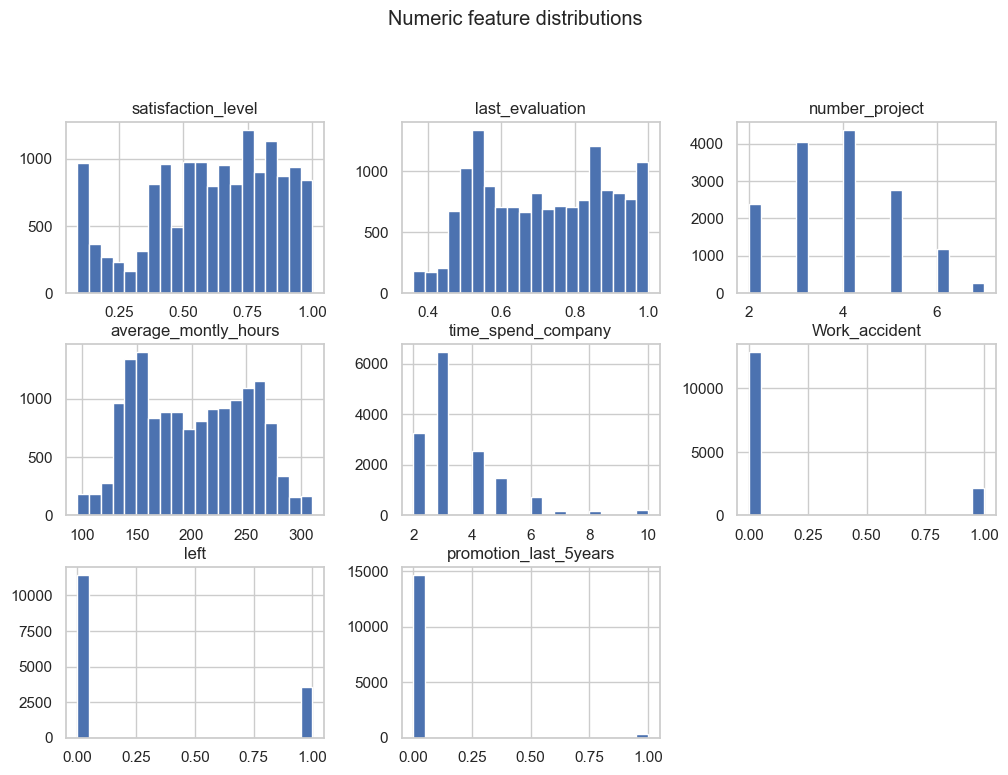

In [18]:
numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Numeric feature distributions", y=1.02)
plt.show()


Attrition vs key numeric features

/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/2933978353.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(["Stayed", "Left"])
/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/2933978353.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(["Stayed", "Left"])


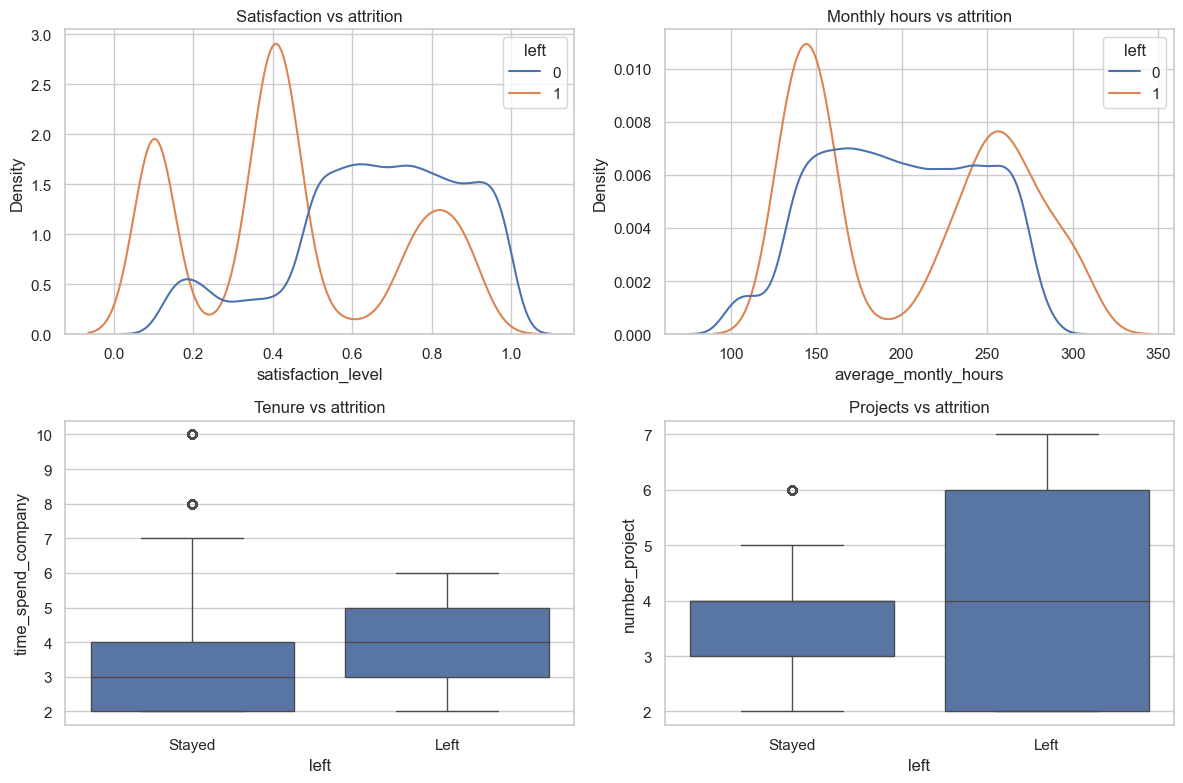

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.kdeplot(data=df, x="satisfaction_level", hue="left", common_norm=False, ax=axes[0,0])
axes[0,0].set_title("Satisfaction vs attrition")

sns.kdeplot(data=df, x="average_montly_hours", hue="left", common_norm=False, ax=axes[0,1])
axes[0,1].set_title("Monthly hours vs attrition")

sns.boxplot(data=df, x="left", y="time_spend_company", ax=axes[1,0])
axes[1,0].set_title("Tenure vs attrition")
axes[1,0].set_xticklabels(["Stayed", "Left"])

sns.boxplot(data=df, x="left", y="number_project", ax=axes[1,1])
axes[1,1].set_title("Projects vs attrition")
axes[1,1].set_xticklabels(["Stayed", "Left"])

plt.tight_layout()
plt.show()


Attrition by department & salary

/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/2281794888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_rate.values, y=dept_rate.index, palette="viridis")


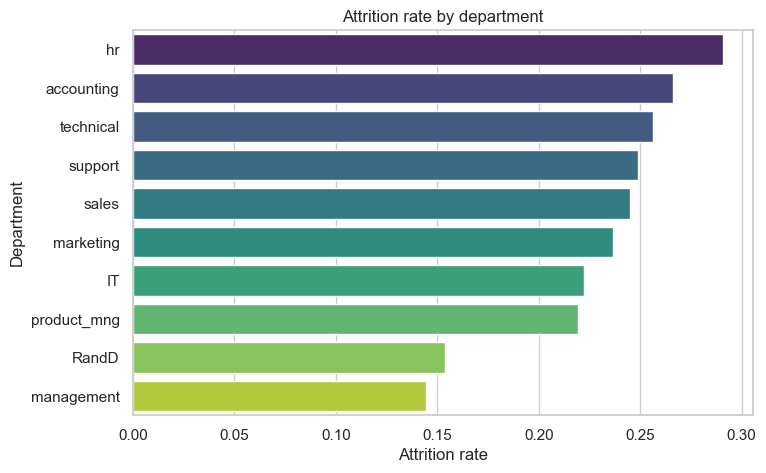

In [20]:
dept_rate = df.groupby("Department")["left"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=dept_rate.values, y=dept_rate.index, palette="viridis")
plt.xlabel("Attrition rate")
plt.title("Attrition rate by department")
plt.show()


/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/521371316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sal_rate.index, y=sal_rate.values, palette="magma")


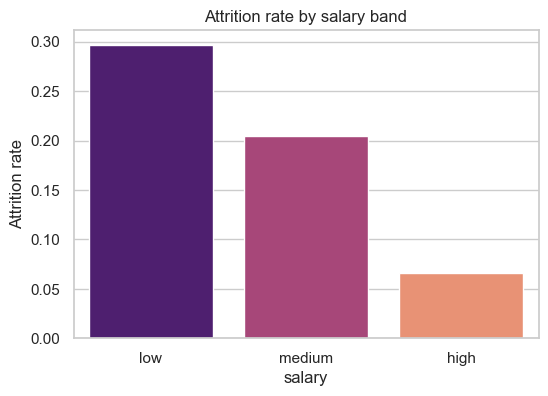

In [21]:
sal_rate = df.groupby("salary")["left"].mean().reindex(["low","medium","high"])
plt.figure(figsize=(6,4))
sns.barplot(x=sal_rate.index, y=sal_rate.values, palette="magma")
plt.ylabel("Attrition rate")
plt.title("Attrition rate by salary band")
plt.show()


Correlation heatmap (numeric) + top correlations

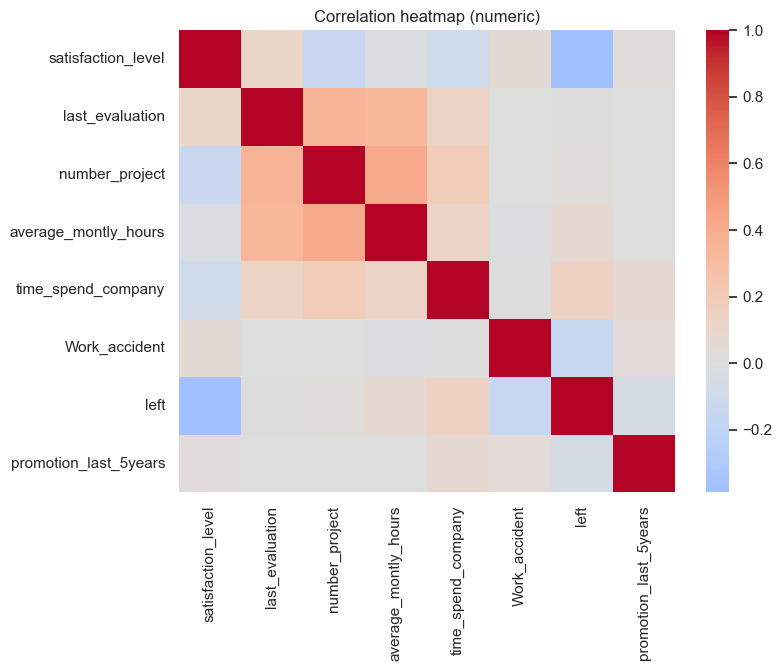

left                     1.000000
time_spend_company       0.144822
average_montly_hours     0.071287
number_project           0.023787
last_evaluation          0.006567
promotion_last_5years   -0.061788
Work_accident           -0.154622
satisfaction_level      -0.388375
Name: left, dtype: float64

In [22]:
plt.figure(figsize=(8,6))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation heatmap (numeric)")
plt.show()

corr["left"].sort_values(ascending=False)


Promotion & accident effects

/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/3485234150.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="promotion_last_5years", y="left", data=df, ax=axes[0], palette="Blues")
/var/folders/w6/0ljs23rn7ng_y8gy7sl52xs40000gn/T/ipykernel_36680/3485234150.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Work_accident", y="left", data=df, ax=axes[1], palette="Greens")


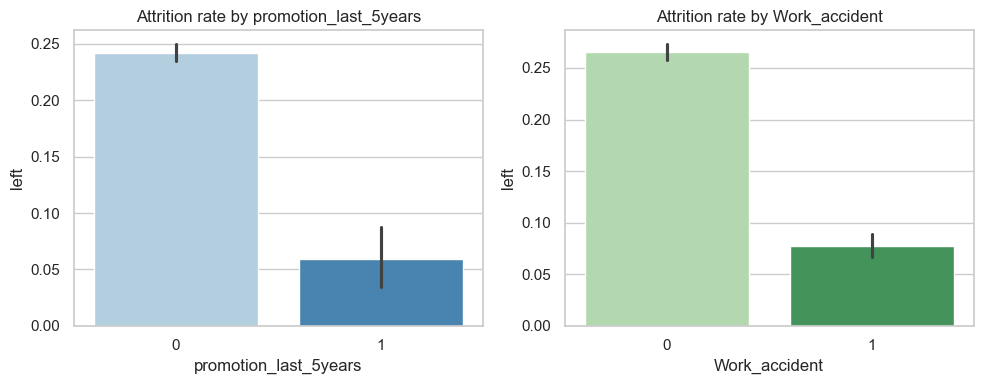

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(x="promotion_last_5years", y="left", data=df, ax=axes[0], palette="Blues")
axes[0].set_title("Attrition rate by promotion_last_5years")
sns.barplot(x="Work_accident", y="left", data=df, ax=axes[1], palette="Greens")
axes[1].set_title("Attrition rate by Work_accident")
plt.tight_layout()
plt.show()


Takeaways (edit after viewing plots)


In [24]:
takeaways = [
    f"Attrition rate: {df['left'].mean()*100:.1f}% (class imbalance present).",
    "Low satisfaction and higher monthly hours show higher attrition density.",
    f"Top attrition departments: {', '.join(dept_rate.head(3).index)}.",
    "Lower salary bands exhibit higher attrition than medium/high.",
    "No recent promotion correlates with higher attrition; workload and tenure matter together.",
]
for t in takeaways:
    print("-", t)


- Attrition rate: 23.8% (class imbalance present).
- Low satisfaction and higher monthly hours show higher attrition density.
- Top attrition departments: hr, accounting, technical.
- Lower salary bands exhibit higher attrition than medium/high.
- No recent promotion correlates with higher attrition; workload and tenure matter together.
